# Import Packages and Define Functions

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as pltticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier 
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IPipeline
from xgboost import XGBClassifier
from joblib import parallel_backend
import pickle
import re
import dataframe_image as dfi
from packages.model_evaluation import class_k_recall, class_k_precision, class_k_f1, class_k_acc
from packages.model_evaluation import evaluate_model

/home/joshua/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Configures axis and title labels
def configure_axislabels_and_title(ax, xlabel, ylabel, title):
    # Set fonts, padding, and fontsize for axis labels and title
    ax.set_xlabel(xlabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 5)

    ax.set_ylabel(ylabel,
                  fontfamily = 'Arial',
                  fontsize = 24,
                  labelpad = 10)

    ax.set_title(title,
                 fontfamily = 'Arial',
                 fontsize = 32,
                 pad = 10)
    
    return None

In [3]:
# Configures ticklabels and tick parameters
def configure_ticklabels_and_params(ax):
    # Set label sizes and tick lengths
    ax.tick_params(axis = 'both',
                   which = 'major',
                   labelsize = 16,
                   length = 8,
                   width = 1)

    # Set font for tick labels on both axes
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        
    return None

In [4]:
# Takes in a feature frame and returns a bar plot of the top 10 features by largest absolute coefficient
def plot_feature_importances(feature_frame):
    fig, ax = plt.subplots(figsize = (16, 8))

    plt.tight_layout()
    
    # Subselect the top 10 coefficients by magnitude
    top_10_features = feature_frame.nlargest(10, 'coefficient')

    # Create horizontal seaborn barplot
    sns.barplot(data = top_10_features, x = 'coefficient', y = 'feature',
                orient = 'h', ax = ax);
    
    return fig, ax

In [5]:
# Takes in a list of tuples of the form (frame, target) and a feature column
# Plots boxplots of the feature for each frame, target pair in a row
# Returns fig, ax objects
def plot_boxplots(frame_targets, column):
    num_frames = len(frame_targets)
    
    # Define columns and figsize based on number of frames
    fig, ax = plt.subplots(1, num_frames, figsize = (8 * num_frames, 8))
    
    plt.tight_layout(pad = 4.0)
    
    # Plot boxplots based on feature column and target for each frame
    for index, (frame, target) in enumerate(frame_targets):
        # If num_frames == 1, ax object is not subscriptable
        if num_frames != 1:
            axis = ax[index]
        else:
            axis = ax
        
        # Plot seaborn boxplot of feature column and target
        sns.boxplot(data = frame,
                    x = frame[column],
                    y = frame[target],
                    orient = 'h',
                    ax = axis);
        
    return fig, ax

In [6]:
# Takes in X-, y-values and a fitted model
# Returns a fig, ax pair containing a seaborn heatmap of the confusion matrix
def plot_confusion_matrix_fancy(X_test, y_test, model):
    matrix = confusion_matrix(y_test, model.predict(X_test))
    
    fig, ax = plt.subplots(figsize = (12, 12))
    
    plt.tight_layout()
    
    # Plot seaborn heatmap, no decimals or scientific notation, no colorbar
    sns.heatmap(matrix, annot = True, fmt = 'g', cmap = 'viridis', linewidths = 1,
                cbar = False, annot_kws = {'fontsize': 24, 'fontfamily': 'Arial'}, ax = ax)
    
    return fig, ax

# Import Dataframes and Models

In [7]:
# Load dataframes
train_multi = pd.read_parquet('../data/cleaned/train_multi.parquet')
X_train_multi = train_multi.drop('classification', axis = 1)
y_train_multi = train_multi.classification
test_multi = pd.read_parquet('../data/cleaned/test_multi.parquet')
X_test_multi = test_multi.drop('classification', axis = 1)
y_test_multi = test_multi.classification
full_multi = pd.concat([train_multi, test_multi], axis = 0)

train_binary = pd.read_parquet('../data/cleaned/train_binary.parquet')
X_train_binary = train_binary.drop('disposition', axis = 1)
y_train_binary = train_binary.disposition
test_binary = pd.read_parquet('../data/cleaned/test_binary.parquet')
X_test_binary = test_binary.drop('disposition', axis = 1)
y_test_binary = test_binary.disposition
full_binary = pd.concat([train_binary, test_binary], axis = 0)

In [10]:
with open('../data/models/binary/binary_base_logistic.pickle', 'rb') as f:
    base_binary_model = pickle.load(f)

base_binary_class_report, base_binary_features = evaluate_model(X_test_binary, y_test_binary, base_binary_model)
base_binary_features.coefficient = base_binary_features.coefficient.abs()

with open('../data/models/binary/binary_xgboost.pickle', 'rb') as f:
    best_binary_model = pickle.load(f)

best_binary_class_report, best_binary_features = evaluate_model(X_test_binary, y_test_binary, best_binary_model)
best_binary_features.coefficient = best_binary_features.coefficient.abs()

with open('../data/models/multi/multi_base_tree.pickle', 'rb') as f:
    base_multi_model = pickle.load(f)

base_multi_class_report, base_multi_features = evaluate_model(X_test_multi, y_test_multi, base_multi_model)
base_multi_features.coefficient = base_multi_features.coefficient.abs()

with open('../data/models/multi/multi_xgboost.pickle', 'rb') as f:
    best_multi_model = pickle.load(f)

best_multi_class_report, best_multi_features = evaluate_model(X_test_multi, y_test_multi, best_multi_model)
best_multi_features.coefficient = best_multi_features.coefficient.abs()

# Classification Reports

In [11]:
# Save classification reports for each model as .png images
# dfi.export(base_binary_class_report, '../images/base_binary_class_report.png', bbox_inches = 'tight')
# dfi.export(best_binary_class_report, '../images/best_binary_class_report.png', bbox_inches = 'tight')
# dfi.export(base_multi_class_report, '../images/base_multi_class_report.png', bbox_inches = 'tight')
# dfi.export(best_multi_class_report, '../images/best_multi_class_report.png', bbox_inches = 'tight')

# Feature Importances

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


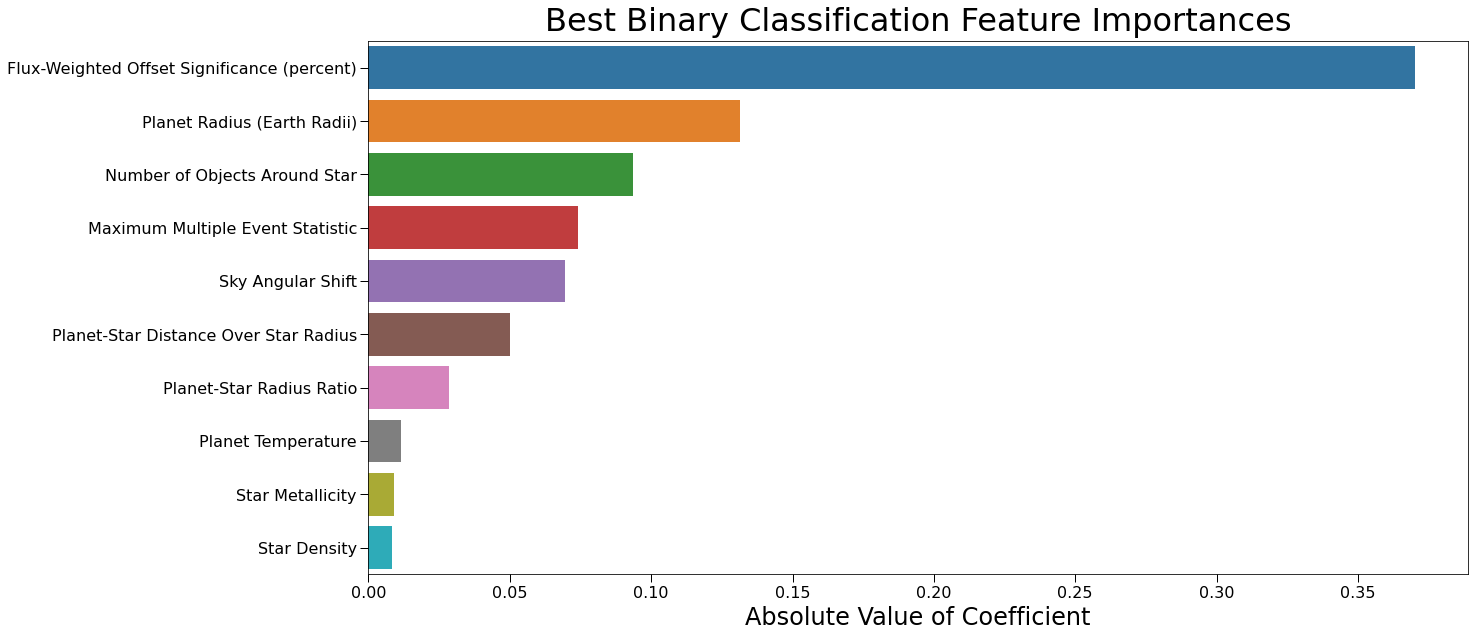

In [12]:
# Create barplot of top 10 feature importances for best binary classification model (XGBoost)
# Create barplot
fig, ax = plot_feature_importances(best_binary_features)

# Configure axis labels, title, ticks, and ticklabels
# Labels selected by manual inspection of top 10 feature importances
configure_axislabels_and_title(ax, 'Absolute Value of Coefficient',
                               None, 'Best Binary Classification Feature Importances')

feature_labels = ['Flux-Weighted Offset Significance (percent)', 'Planet Radius (Earth Radii)',
                  'Number of Objects Around Star', 'Maximum Multiple Event Statistic', 'Sky Angular Shift',
                  'Planet-Star Distance Over Star Radius', 'Planet-Star Radius Ratio', 'Planet Temperature',
                  'Star Metallicity', 'Star Density']

configure_ticklabels_and_params(ax)

ax.set_yticklabels(feature_labels);

# Save figure as .png
# plt.savefig('../images/best_binary_feature_importances.png', bbox_inches = 'tight')

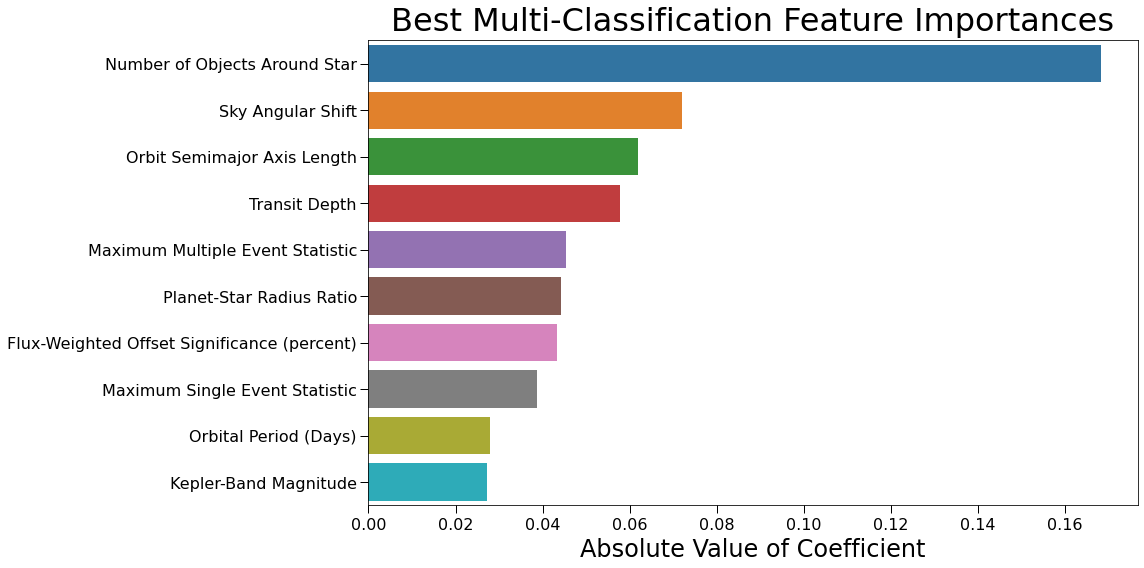

In [13]:
# Create barplot of top 10 feature importances for best multi-class classification model (XGBoost)
# Create barplot
fig, ax = plot_feature_importances(best_multi_features)

# Configure axis labels, title, ticks, and ticklabels
# Labels selected by manual inspection of top 10 feature importances
configure_axislabels_and_title(ax, 'Absolute Value of Coefficient',
                               None, 'Best Multi-Classification Feature Importances')

feature_labels = ['Number of Objects Around Star', 'Sky Angular Shift', 'Orbit Semimajor Axis Length',
                  'Transit Depth', 'Maximum Multiple Event Statistic', 'Planet-Star Radius Ratio',
                  'Flux-Weighted Offset Significance (percent)', 'Maximum Single Event Statistic',
                  'Orbital Period (Days)', 'Kepler-Band Magnitude']

configure_ticklabels_and_params(ax)

ax.set_yticklabels(feature_labels);

plt.tight_layout()

# Save figure as .png
# plt.savefig('../images/best_multi_feature_importances.png', bbox_inches = 'tight')

# Feature Distributions

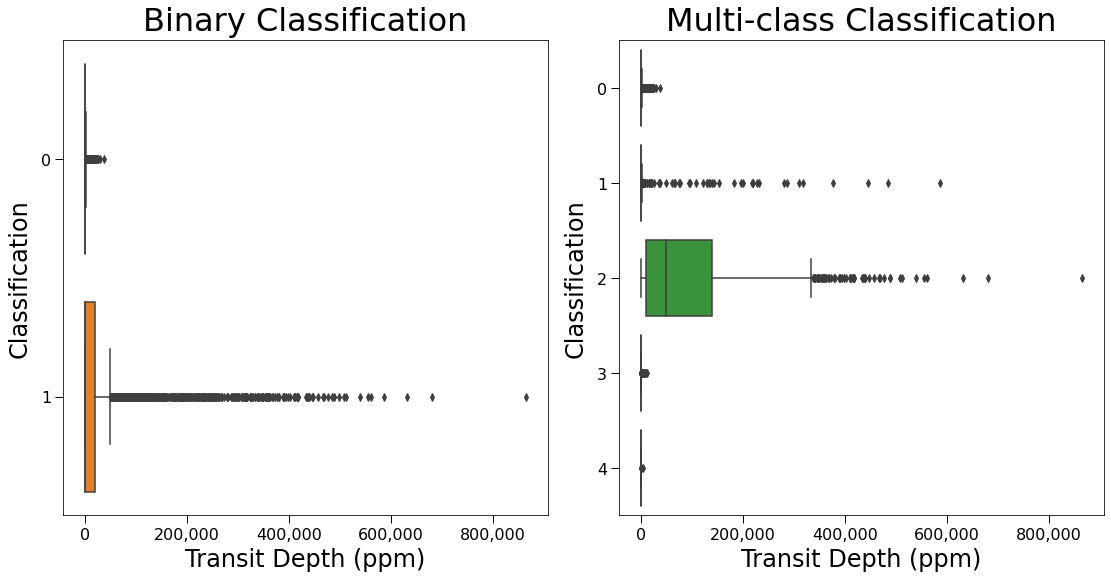

In [14]:
# Create boxplots for transit depth feature
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'transit_depth')

# Configure axis labels, title, ticks, and ticklabels
for axis in ax:
    configure_axislabels_and_title(axis, 'Transit Depth (ppm)',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

# Save figure as .png
# plt.savefig('../images/transit_depth_boxplots.png', bbox_inches = 'tight')

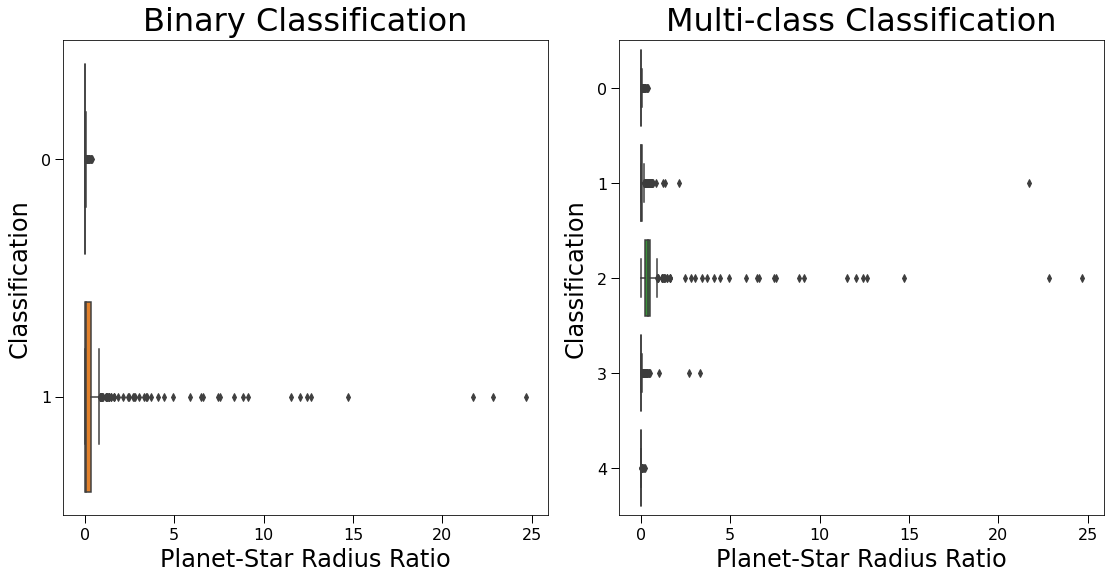

In [15]:
# Create boxplots for star radius feature
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'planet_star_radius_ratio')

# Configure axis labels, title, ticks, and ticklabels
for axis in ax:
    configure_axislabels_and_title(axis, 'Planet-Star Radius Ratio',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

# Save figure as .png
# plt.savefig('../images/planet_star_radius_ratio_boxplots.png', bbox_inches = 'tight')

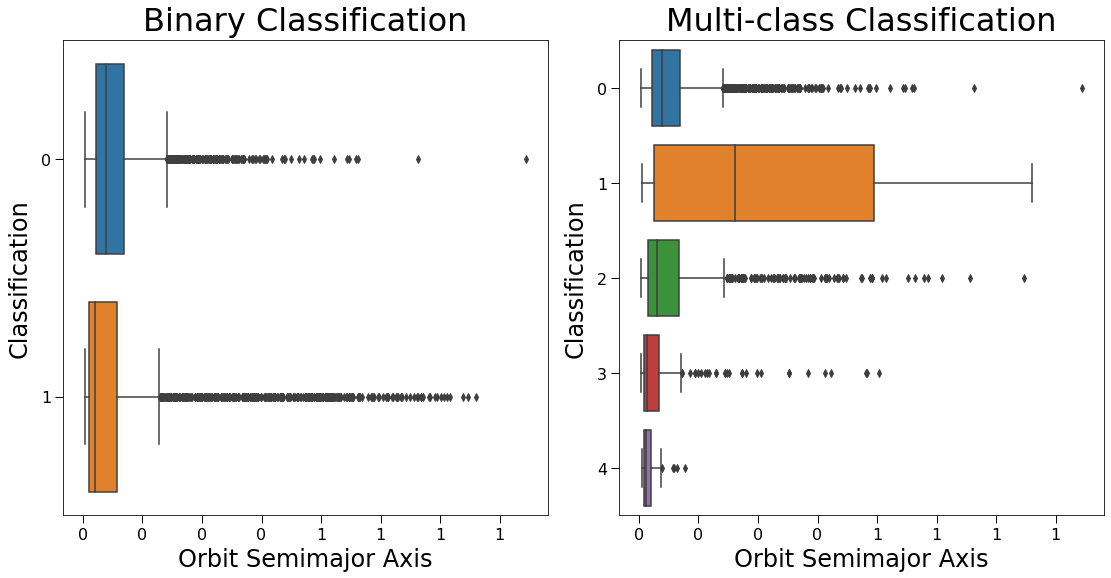

In [16]:
# Create boxplots for number of transits feature
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'orbit_semimajor_axis')

# Configure axis labels, title, ticks, and ticklabels
for axis in ax:
    configure_axislabels_and_title(axis, 'Orbit Semimajor Axis',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

# Save figure as .png
# plt.savefig('../images/orbit_semimajor_axis_boxplots.png', bbox_inches = 'tight')

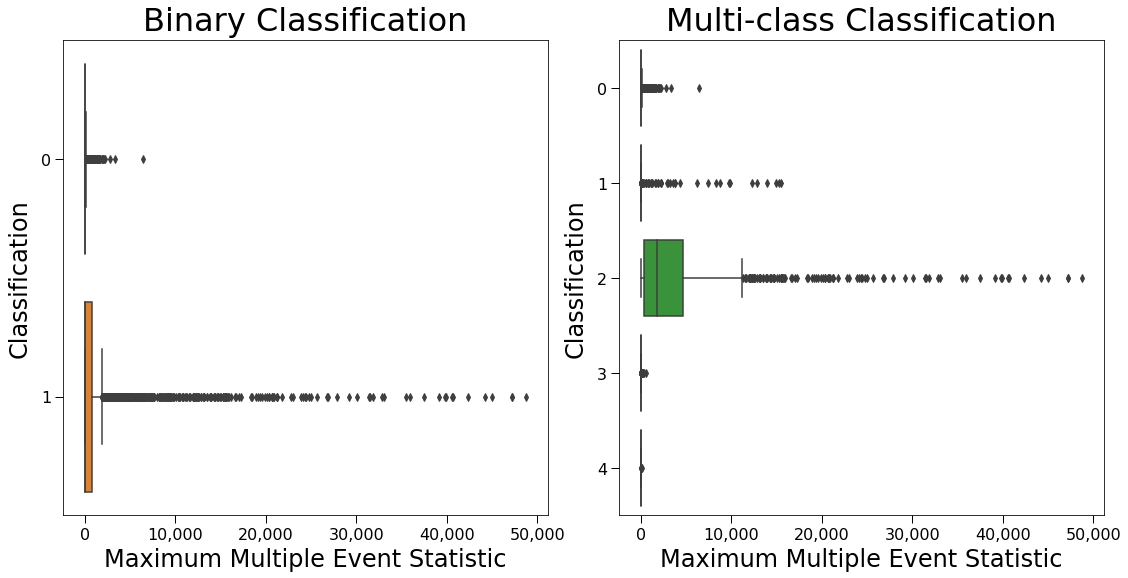

In [17]:
# Create boxplots for transit signal to noise ratio feature
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'max_multi_event_stat')

# Configure axis labels, title, ticks, and ticklabels
for axis in ax:
    configure_axislabels_and_title(axis, 'Maximum Multiple Event Statistic',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

# Save figure as .png
# plt.savefig('../images/max_multi_event_stat_boxplots.png', bbox_inches = 'tight')

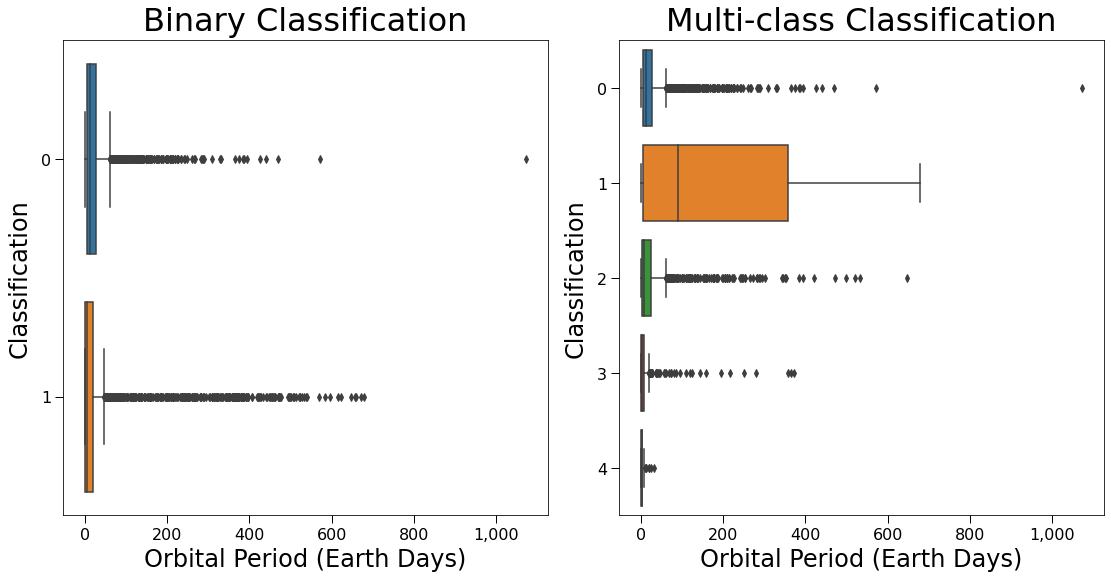

In [18]:
# Create boxplots for orbital period feature
fig, ax = plot_boxplots([(full_binary, 'disposition'), (full_multi, 'classification')], 'orbital_period')

# Configure axis labels, title, ticks, and ticklabels
for axis in ax:
    configure_axislabels_and_title(axis, 'Orbital Period (Earth Days)',
                               'Classification', None)
    axis.get_xaxis().set_major_formatter(pltticker.FuncFormatter(lambda x, p: format(int(x),',')))
    configure_ticklabels_and_params(axis)

ax[0].set_title('Binary Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);
ax[1].set_title('Multi-class Classification', fontfamily = 'Arial', fontsize = 32, pad = 10);

# Save figure as .png
# plt.savefig('../images/orbital_period_boxplots.png', bbox_inches = 'tight')

# Confusion Matrices

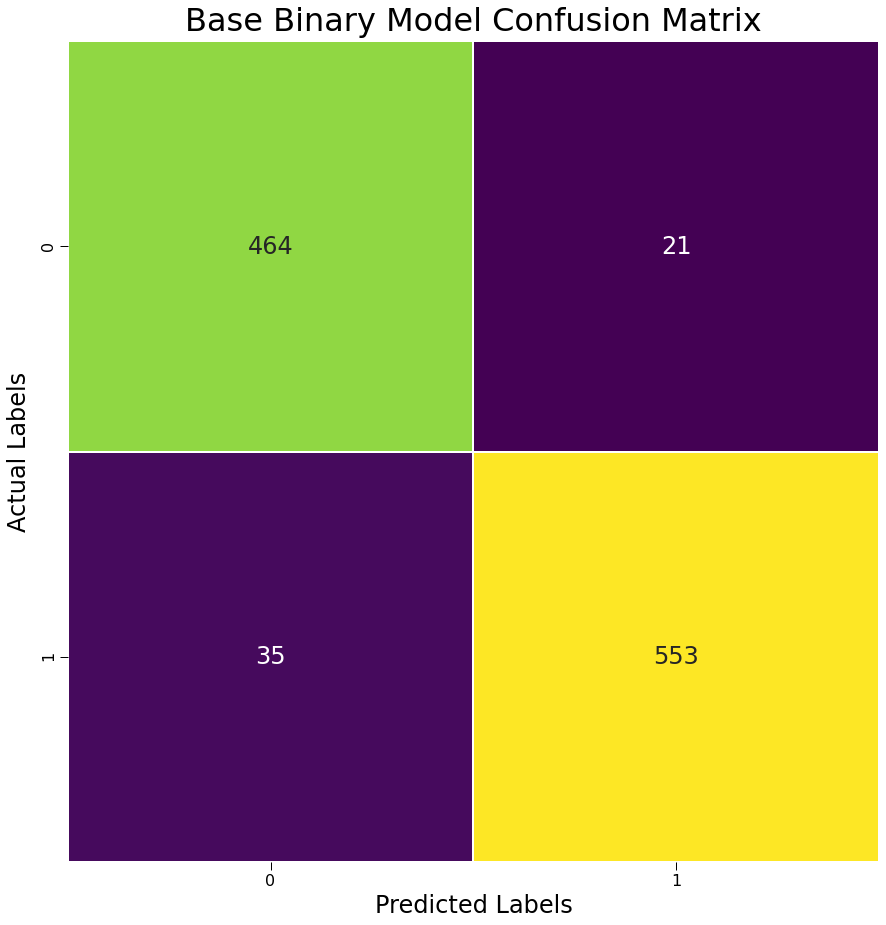

In [19]:
# Create confusion matrix for base binary classification model (logistic regression)
fig, ax = plot_confusion_matrix_fancy(X_test_binary, y_test_binary, base_binary_model)

# Configure axis labels, title, ticks, and ticklabels
configure_axislabels_and_title(ax, 'Predicted Labels',
                               'Actual Labels', 'Base Binary Model Confusion Matrix')

configure_ticklabels_and_params(ax)

# Save figure as .png
# plt.savefig('../images/base_binary_confusion_matrix.png', bbox_inches = 'tight')

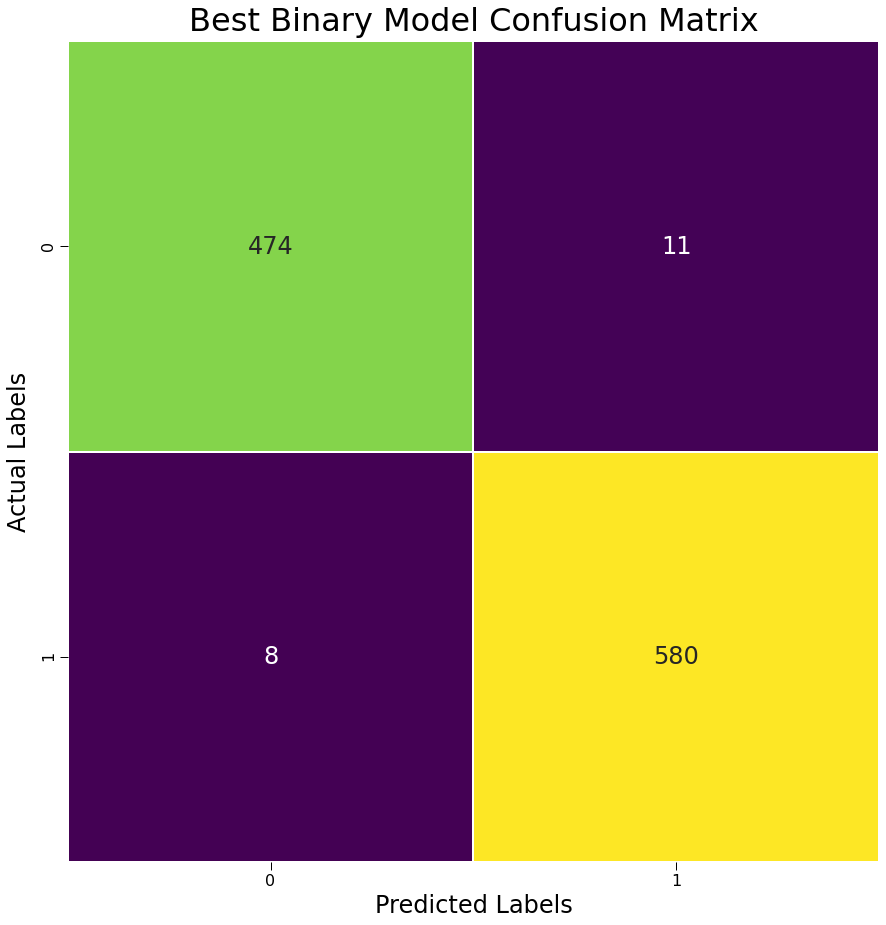

In [20]:
# Create confusion matrix for final binary classification model (XGBoost)
fig, ax = plot_confusion_matrix_fancy(X_test_binary, y_test_binary, best_binary_model)

# Configure axis labels, title, ticks, and ticklabels
configure_axislabels_and_title(ax, 'Predicted Labels',
                               'Actual Labels', 'Best Binary Model Confusion Matrix')

configure_ticklabels_and_params(ax)

# Save figure as .png
# plt.savefig('../images/best_binary_confusion_matrix.png', bbox_inches = 'tight')

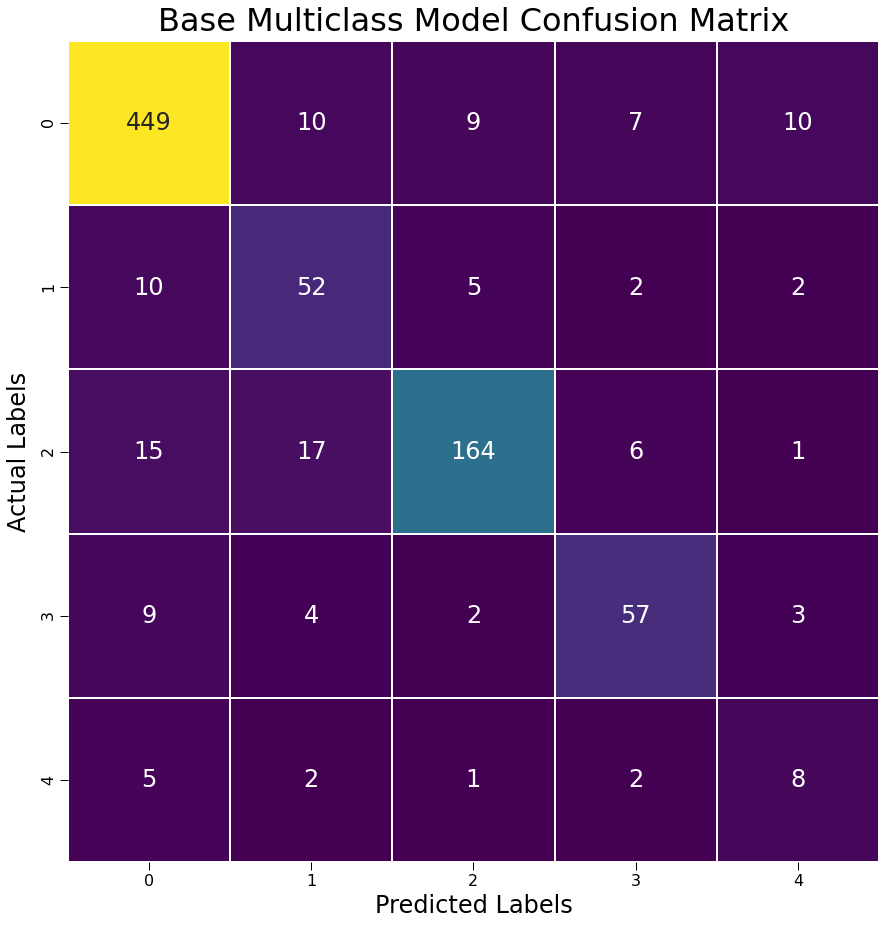

In [21]:
# Create confusion matrix for base multi-class classification model (decision tree classifier)
fig, ax = plot_confusion_matrix_fancy(X_test_multi, y_test_multi, base_multi_model)

# Configure axis labels, title, ticks, and ticklabels
configure_axislabels_and_title(ax, 'Predicted Labels',
                               'Actual Labels', 'Base Multiclass Model Confusion Matrix')

configure_ticklabels_and_params(ax)

# Save figure as .png
# plt.savefig('../images/base_multi_confusion_matrix.png', bbox_inches = 'tight')

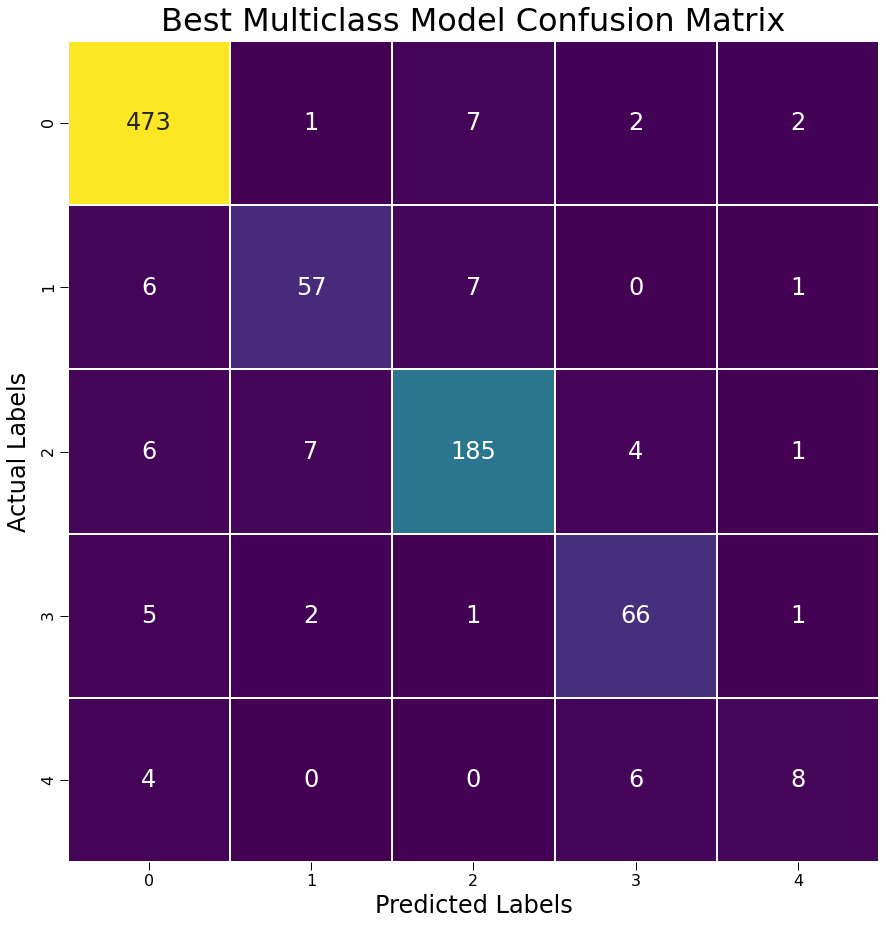

In [22]:
# Create confusion matrix for best multi-class classification model (XGBoost)
fig, ax = plot_confusion_matrix_fancy(X_test_multi, y_test_multi, best_multi_model)

# Configure axis labels, title, ticks, and ticklabels
configure_axislabels_and_title(ax, 'Predicted Labels',
                               'Actual Labels', 'Best Multiclass Model Confusion Matrix')

configure_ticklabels_and_params(ax)

# Save figure as .png
# plt.savefig('../images/best_multi_confusion_matrix.png', bbox_inches = 'tight')